In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import warnings
import logging
import pickle
import os

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning, message="Setting penalty='none' will ignore the C and l1_ratio parameters")
warnings.filterwarnings("ignore", category=UserWarning, message="l1_ratio must be between 0 and 1; got (l1_ratio=None)")
warnings.filterwarnings("ignore", category=ConvergenceWarning)
logging.basicConfig(level=logging.ERROR)

np.random.seed(21)

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# Data Cleaning and Preprocessing & Feature Engineering & Feature Selection


In [2]:
# root_path = '/content/drive/MyDrive/Tasks/MaidsCC'
root_path = "\\".join(os.path.abspath(".").split('\\')[:-1])
data_path = os.path.join(root_path, "Data")
results_path = os.path.join(root_path, "Results")

In [3]:
train_data = pd.read_csv(os.path.join(data_path, "train.csv"))
test_data = pd.read_csv(os.path.join(data_path, "test.csv"))

In [4]:
train_data.shape , test_data.shape

((2000, 21), (1000, 21))

In [5]:
def save_object(obj, filename, path):
    filename = os.path.join(path, filename)
    with open(filename + ".pkl", 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
    outp.close()

def load_object(filename, path):
    filename = os.path.join(path, filename)
    with open(filename + ".pkl", 'rb') as outp:
        loaded_object = pickle.load(outp)
    outp.close()
    return loaded_object

In [6]:
'''
    Remove all rows from 'train_data' that contain any missing values.
    The 'inplace=True' parameter modifies the DataFrame in place, meaning it will directly alter 'train_data' without needing to reassign it.
'''
train_data.dropna(inplace=True)

X = train_data.drop("price_range",axis=1)
y = train_data["price_range"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=21)

In [7]:
median_vector = X_train.median()
median_vector = median_vector.tolist()
# save_object(median_vector, 'median_vector', results_path)

## First Experiment:
A simple classification algorithm depends on setting thresholds for different RAM sizes

              precision    recall  f1-score   support

           0       0.95      0.79      0.86       113
           1       0.65      0.68      0.66       107
           2       0.56      0.67      0.61        84
           3       0.87      0.84      0.86        95

    accuracy                           0.75       399
   macro avg       0.76      0.74      0.75       399
weighted avg       0.77      0.75      0.75       399



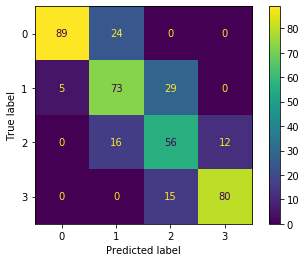

In [8]:
def classify_value(value):
    ranges = [
        (0, 1100, 0),
        (1101, 2100, 1),
        (2101, 3100, 2)
    ]
    for start, end, label in ranges:
        if start <= value <= end:
            return label
    return 3
y_preds = X_val['ram'].apply(classify_value)
print(classification_report(y_val, y_preds))
cf = confusion_matrix(y_val, y_preds)
disp = ConfusionMatrixDisplay(cf)
disp.plot()
plt.show()

## Second Experiment:
Work on full data

In [9]:
X_train_2 = X_train.copy()
X_val_2 = X_val.copy()

## Third Experiment:
Work on all data, but with standardization

In [10]:
X_train_3 = X_train.copy()
X_val_3 = X_val.copy()
sc_3 = StandardScaler()
X_train_3 = sc_3.fit_transform(X_train_3)
X_val_3 = sc_3.transform(X_val_3)

## Fourth Experiment:
Work on the most important three features according to the corelation matrix (Battery power, Total pxs, Ram)

In [11]:
X_train_4 = X_train.copy()
X_val_4 = X_val.copy()
X_train_4['total_pxs'] = X_train_4['px_height'] * X_train_4['px_width']
X_val_4['total_pxs'] = X_val_4['px_height'] * X_val_4['px_width']
columns_to_keep = ['battery_power', 'total_pxs', 'ram']
columns_to_drop = [col for col in X_train_4.columns if col not in columns_to_keep]
X_train_4 = X_train_4.drop(columns=columns_to_drop)
X_val_4 = X_val_4.drop(columns=columns_to_drop)
sc_4 = StandardScaler()
X_train_4 = sc_4.fit_transform(X_train_4)
X_val_4 = sc_4.transform(X_val_4)

## Fifth Experiment:
Work on all the features that have a positive association with the price according to the correlation matrix

In [12]:
X_train_5 = X_train.copy()
X_val_5 = X_val.copy()
X_train_5['total_pxs'] = X_train_5['px_height'] * X_train_5['px_width']
X_val_5['total_pxs'] = X_val_5['px_height'] * X_val_5['px_width']

X_train_5['sc_area'] = X_train_5['sc_h'] * X_train_5['sc_w']
X_val_5['sc_area'] = X_val_5['sc_h'] * X_val_5['sc_w']

columns_to_keep = ['battery_power', 'fc', 'int_memory', 'm_dep', 'mobile_wt',
                   'n_cores', 'pc', 'total_pxs', 'ram', 'sc_area', 'talk_time', 'three_g']
columns_to_drop = [col for col in X_train_5.columns if col not in columns_to_keep]
X_train_5 = X_train_5.drop(columns=columns_to_drop)
X_val_5 = X_val_5.drop(columns=columns_to_drop)
sc_5 = StandardScaler()
X_train_5 = sc_5.fit_transform(X_train_5)
X_val_5 = sc_5.transform(X_val_5)

## VI Experiment:
Extracting the importance of features using DecisionTreeClassifier

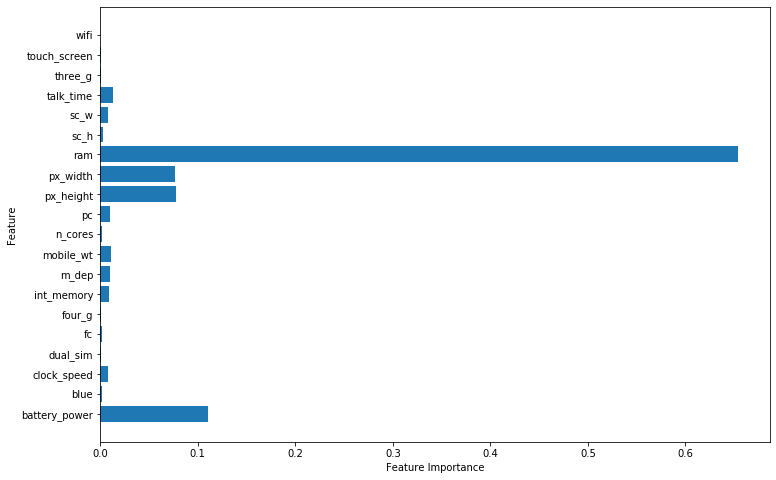

In [13]:
train_data.dropna(inplace=True)
X = train_data.drop("price_range",axis=1)
y = train_data["price_range"]
clf_all = DecisionTreeClassifier(random_state=42)
clf_all.fit(X, y)
n_features = X.shape[1]
plt.figure(figsize=(12, 8))
plt.barh(range(n_features), clf_all.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X.columns)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

In [14]:
X_train_6 = X_train.copy()
X_val_6 = X_val.copy()
X_train_6['total_pxs'] = X_train_6['px_height'] * X_train_6['px_width']
X_val_6['total_pxs'] = X_val_6['px_height'] * X_val_6['px_width']

X_train_6['sc_area'] = X_train_6['sc_h'] * X_train_6['sc_w']
X_val_6['sc_area'] = X_val_6['sc_h'] * X_val_6['sc_w']

columns_to_keep = ['talk_time', 'sc_area', 'ram', 'total_pxs', 'pc',
                   'mobile_wt', 'm_dep', 'int_memory', 'clock_speed', 'battery_power']
columns_to_drop = [col for col in X_train_6.columns if col not in columns_to_keep]
X_train_6 = X_train_6.drop(columns=columns_to_drop)
X_val_6 = X_val_6.drop(columns=columns_to_drop)
sc_6 = StandardScaler()
X_train_6 = sc_6.fit_transform(X_train_6)
X_val_6 = sc_6.transform(X_val_6)

## Seventh Experiment:
Use PCA to reduce data dimensions

In [15]:
pca = PCA(n_components=0.95)
X_train_ = np.array(X_train)
X_val_ = np.array(X_val)
X_train_7 = pca.fit_transform(X_train_)
X_val_7 = pca.transform(X_val_)

## VIII Experiment:
Using Recursive Feature Elimination (**RFE**) (select features by **recursively considering smaller and smaller sets of features**).

([], <a list of 0 Text yticklabel objects>)

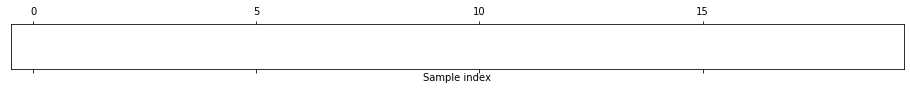

In [16]:
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=40)
select.fit(X_train, y_train)
mask = select.get_support()
X_train_ = np.array(X_train)
X_val_ = np.array(X_val)
X_train_8 = X_train_[:, mask]
X_val_8 = X_val_[:, mask]
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

## Ninth Experiment:
drift detection (by DDM or ADWIN)

# Modelling

In [17]:
def evaluate_model(model, x_val, y_val):
    y_preds = model.predict(x_val)
    print(classification_report(y_val,y_preds))
    cf = confusion_matrix(y_val,y_preds)
    disp = ConfusionMatrixDisplay(cf)
    disp.plot()
    plt.show()

In [18]:
def train_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train,y_train)
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    return train_acc, test_acc

In [19]:
model_params = {
    'svm': {
        'model': SVC(),
        'params': {
            'kernel': ['linear', 'poly', 'rbf'],
            'C': [1, 5, 10],
            'gamma': ['scale', 'auto']
        }
    },
    'rfc': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [10, 50, 100],
            'max_depth': [None, 10, 20, 30],
            'criterion': ['gini', 'entropy']
        }
    },
    'dtc': {
        'model': DecisionTreeClassifier(),
        'params': {
            'max_depth': [3, 5, 10, None],
            'criterion': ['gini', 'entropy']
        }
    },
     'log_reg_1': {
        'model': LogisticRegression(),
        'params': {
            'penalty': ['l2'],
            'C': [0.1, 1, 10, 100],
            'solver': ['saga']
        }
    },
     'log_reg_2': {
        'model': LogisticRegression(),
        'params': {
            'penalty': ['elasticnet'],
            'C': [0.1, 1, 10, 100],
            'solver': ['saga'],
            'l1_ratio': [0.5, 0.7, 0.9]
        }
     },
    'knn': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 11, 19],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski']
        }
    },
    'gbc': {
        'model': GradientBoostingClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    },
    'mlp': {
        'model': MLPClassifier(),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'activation': ['tanh', 'relu'],
            'solver': ['sgd', 'adam'],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate': ['constant', 'adaptive']
        }
    }
}

In [20]:
def run_grid_search(X_train, y_train):
    scores=[]
    for model_name, mp in tqdm(model_params.items()):
        try:
            clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
            clf.fit(X_train, y_train)
            scores.append({
                'model':model_name,
                'best_score':clf.best_score_,
                'best_params':clf.best_params_
            })
        except ValueError as e:
            print(f"An error occurred during grid search: {e}")
    return scores

## Second Experiment:

In [21]:
%%time
scores = run_grid_search(X_train_2, y_train)
for models in scores:
    print(models)

100%|██████████| 8/8 [14:40<00:00, 110.12s/it]

Wall time: 14min 40s


[{'model': 'svm',
  'best_score': 0.9736203939196783,
  'best_params': {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}},
 {'model': 'rfc',
  'best_score': 0.8731038425898543,
  'best_params': {'criterion': 'entropy',
   'max_depth': None,
   'n_estimators': 100}},
 {'model': 'dtc',
  'best_score': 0.8404428146132765,
  'best_params': {'criterion': 'entropy', 'max_depth': 10}},
 {'model': 'log_reg_1',
  'best_score': 0.6363281481043355,
  'best_params': {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}},
 {'model': 'log_reg_2',
  'best_score': 0.6363281481043355,
  'best_params': {'C': 100,
   'l1_ratio': 0.9,
   'penalty': 'elasticnet',
   'solver': 'saga'}},
 {'model': 'knn',
  'best_score': 0.9302695136136906,
  'best_params': {'metric': 'manhattan',
   'n_neighbors': 19,
   'weights': 'distance'}},
 {'model': 'gbc',
  'best_score': 0.9057885294059659,
  'best_params': {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}},
 {'model': 'mlp',
  'best_score': 0.6733936633741449,
  'be

## Third Experiment:

In [22]:
%%time
scores = run_grid_search(X_train_3, y_train)
for models in scores:
    print(models)

100%|██████████| 8/8 [15:15<00:00, 114.39s/it]

Wall time: 15min 15s


[{'model': 'svm',
  'best_score': 0.9623193549023087,
  'best_params': {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}},
 {'model': 'rfc',
  'best_score': 0.8724768833422054,
  'best_params': {'criterion': 'entropy',
   'max_depth': 10,
   'n_estimators': 100}},
 {'model': 'dtc',
  'best_score': 0.8404546440330435,
  'best_params': {'criterion': 'entropy', 'max_depth': 10}},
 {'model': 'log_reg_1',
  'best_score': 0.9654502080006309,
  'best_params': {'C': 100, 'penalty': 'l2', 'solver': 'saga'}},
 {'model': 'log_reg_2',
  'best_score': 0.9654502080006309,
  'best_params': {'C': 10,
   'l1_ratio': 0.9,
   'penalty': 'elasticnet',
   'solver': 'saga'}},
 {'model': 'knn',
  'best_score': 0.6413083338262259,
  'best_params': {'metric': 'manhattan',
   'n_neighbors': 19,
   'weights': 'distance'}},
 {'model': 'gbc',
  'best_score': 0.9013899568226179,
  'best_params': {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50}},
 {'model': 'mlp',
  'best_score': 0.9547702135210269,
  'best_

## Fourth Experiment:

In [24]:
%%time
scores = run_grid_search(X_train_4, y_train)
for models in scores:
    print(models)

100%|██████████| 8/8 [10:47<00:00, 80.98s/it] 

[{'model': 'svm', 'best_score': 0.9321720786262102, 'best_params': {'C': 5, 'gamma': 'scale', 'kernel': 'linear'}}, {'model': 'rfc', 'best_score': 0.9114429920545731, 'best_params': {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 50}}, {'model': 'dtc', 'best_score': 0.8863015319098597, 'best_params': {'criterion': 'entropy', 'max_depth': None}}, {'model': 'log_reg_1', 'best_score': 0.9296602984956921, 'best_params': {'C': 10, 'penalty': 'l2', 'solver': 'saga'}}, {'model': 'log_reg_2', 'best_score': 0.9302892293133022, 'best_params': {'C': 1, 'l1_ratio': 0.7, 'penalty': 'elasticnet', 'solver': 'saga'}}, {'model': 'knn', 'best_score': 0.9076713787188739, 'best_params': {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}}, {'model': 'gbc', 'best_score': 0.907673350288835, 'best_params': {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}}, {'model': 'mlp', 'best_score': 0.9409711953628674, 'best_params': {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_

[{'model': 'svm',
  'best_score': 0.9321720786262102,
  'best_params': {'C': 5, 'gamma': 'scale', 'kernel': 'linear'}},
 {'model': 'rfc',
  'best_score': 0.9114429920545731,
  'best_params': {'criterion': 'entropy',
   'max_depth': 30,
   'n_estimators': 50}},
 {'model': 'dtc',
  'best_score': 0.8863015319098597,
  'best_params': {'criterion': 'entropy', 'max_depth': None}},
 {'model': 'log_reg_1',
  'best_score': 0.9296602984956921,
  'best_params': {'C': 10, 'penalty': 'l2', 'solver': 'saga'}},
 {'model': 'log_reg_2',
  'best_score': 0.9302892293133022,
  'best_params': {'C': 1,
   'l1_ratio': 0.7,
   'penalty': 'elasticnet',
   'solver': 'saga'}},
 {'model': 'knn',
  'best_score': 0.9076713787188739,
  'best_params': {'metric': 'manhattan',
   'n_neighbors': 19,
   'weights': 'distance'}},
 {'model': 'gbc',
  'best_score': 0.907673350288835,
  'best_params': {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}},
 {'model': 'mlp',
  'best_score': 0.9409711953628674,
  'best_pa

## Fifth Experiment:

In [25]:
%%time
scores = run_grid_search(X_train_5, y_train)
for models in scores:
    print(models)

100%|██████████| 8/8 [13:14<00:00, 99.37s/it] 

{'model': 'svm', 'best_score': 0.9321681354862879, 'best_params': {'C': 5, 'gamma': 'scale', 'kernel': 'linear'}}
{'model': 'rfc', 'best_score': 0.8718597819443623, 'best_params': {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 50}}
{'model': 'dtc', 'best_score': 0.8630586936377437, 'best_params': {'criterion': 'entropy', 'max_depth': 10}}
{'model': 'log_reg_1', 'best_score': 0.9327911515940144, 'best_params': {'C': 100, 'penalty': 'l2', 'solver': 'saga'}}
{'model': 'log_reg_2', 'best_score': 0.9334240255515468, 'best_params': {'C': 1, 'l1_ratio': 0.9, 'penalty': 'elasticnet', 'solver': 'saga'}}
{'model': 'knn', 'best_score': 0.7380453855405059, 'best_params': {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}}
{'model': 'gbc', 'best_score': 0.8988722619822165, 'best_params': {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}}
{'model': 'mlp', 'best_score': 0.9346858303266892, 'best_params': {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes':

## VI Experiment:

In [28]:
%%time
scores = run_grid_search(X_train_6, y_train)
for models in scores:
    print(models)

100%|██████████| 8/8 [13:13<00:00, 99.24s/it] 

{'model': 'svm', 'best_score': 0.9277656197630172, 'best_params': {'C': 5, 'gamma': 'scale', 'kernel': 'linear'}}
{'model': 'rfc', 'best_score': 0.8825496342737722, 'best_params': {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 100}}
{'model': 'dtc', 'best_score': 0.8599219258295381, 'best_params': {'criterion': 'entropy', 'max_depth': None}}
{'model': 'log_reg_1', 'best_score': 0.9283965221505885, 'best_params': {'C': 100, 'penalty': 'l2', 'solver': 'saga'}}
{'model': 'log_reg_2', 'best_score': 0.9290234813982374, 'best_params': {'C': 10, 'l1_ratio': 0.9, 'penalty': 'elasticnet', 'solver': 'saga'}}
{'model': 'knn', 'best_score': 0.7468445022771633, 'best_params': {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}}
{'model': 'gbc', 'best_score': 0.9007570828650854, 'best_params': {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}}
{'model': 'mlp', 'best_score': 0.9321799649060546, 'best_params': {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_siz

## Seventh Experiment:

In [29]:
%%time
scores = run_grid_search(X_train_7, y_train)
for models in scores:
    print(models)

## VIII Experiment:

In [ ]:
%%time
scores = run_grid_search(X_train_8, y_train)
for models in scores:
    print(models)

The best is : ......

## Infrence
Building a final model

In [ ]:
# from sklearn.pipeline import Pipeline
# pipeline = Pipeline([
#  ('std_scaler', StandardScaler()),
#  ('Model' , SVC(C=10, kernel='linear', gamma=0.5)),
# ])

# pipeline.fit(X_train, y_train)
# evaluate_model(pipeline, X_val, y_val)

In [ ]:
# X_test = test_data.drop("id",axis=1)
# X_test = X_test[list(X.columns)]

# y_test_preds = pipeline.predict(X_test)
# test_data["price_range"] = y_test_preds
# test_data.sample(10)

In [ ]:
# save_object(pipeline, 'pipeline', results_path)